In [104]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import roc_auc_score, make_scorer
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split, cross_val_score
from lightgbm import LGBMClassifier

import warnings
warnings.filterwarnings('ignore')

In [105]:
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')
ss = pd.read_csv('sample_submission.csv')

In [111]:
train.head()

,id,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,0,15674932,Okwudilichukwu,668,France,Male,33.0,3,0.00,2,1.0,0.0,181449.97,0
1,1,15749177,Okwudiliolisa,627,France,Male,33.0,1,0.00,2,1.0,1.0,49503.50,0
2,2,15694510,Hsueh,678,France,Male,40.0,10,0.00,2,1.0,0.0,184866.69,0
3,3,15741417,Kao,581,France,Male,34.0,2,148882.54,1,1.0,1.0,84560.88,0
4,4,15766172,Chiemenam,716,Spain,Male,33.0,5,0.00,2,1.0,1.0,15068.83,0


In [106]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 165034 entries, 0 to 165033
Data columns (total 14 columns):
 #   Column           Non-Null Count   Dtype  
---  ------           --------------   -----  
 0   id               165034 non-null  int64  
 1   CustomerId       165034 non-null  int64  
 2   Surname          165034 non-null  object 
 3   CreditScore      165034 non-null  int64  
 4   Geography        165034 non-null  object 
 5   Gender           165034 non-null  object 
 6   Age              165034 non-null  float64
 7   Tenure           165034 non-null  int64  
 8   Balance          165034 non-null  float64
 9   NumOfProducts    165034 non-null  int64  
 10  HasCrCard        165034 non-null  float64
 11  IsActiveMember   165034 non-null  float64
 12  EstimatedSalary  165034 non-null  float64
 13  Exited           165034 non-null  int64  
dtypes: float64(5), int64(6), object(3)
memory usage: 17.6+ MB


In [108]:
train.Exited.value_counts(normalize=True)

Exited
0    0.788401
1    0.211599
Name: proportion, dtype: float64

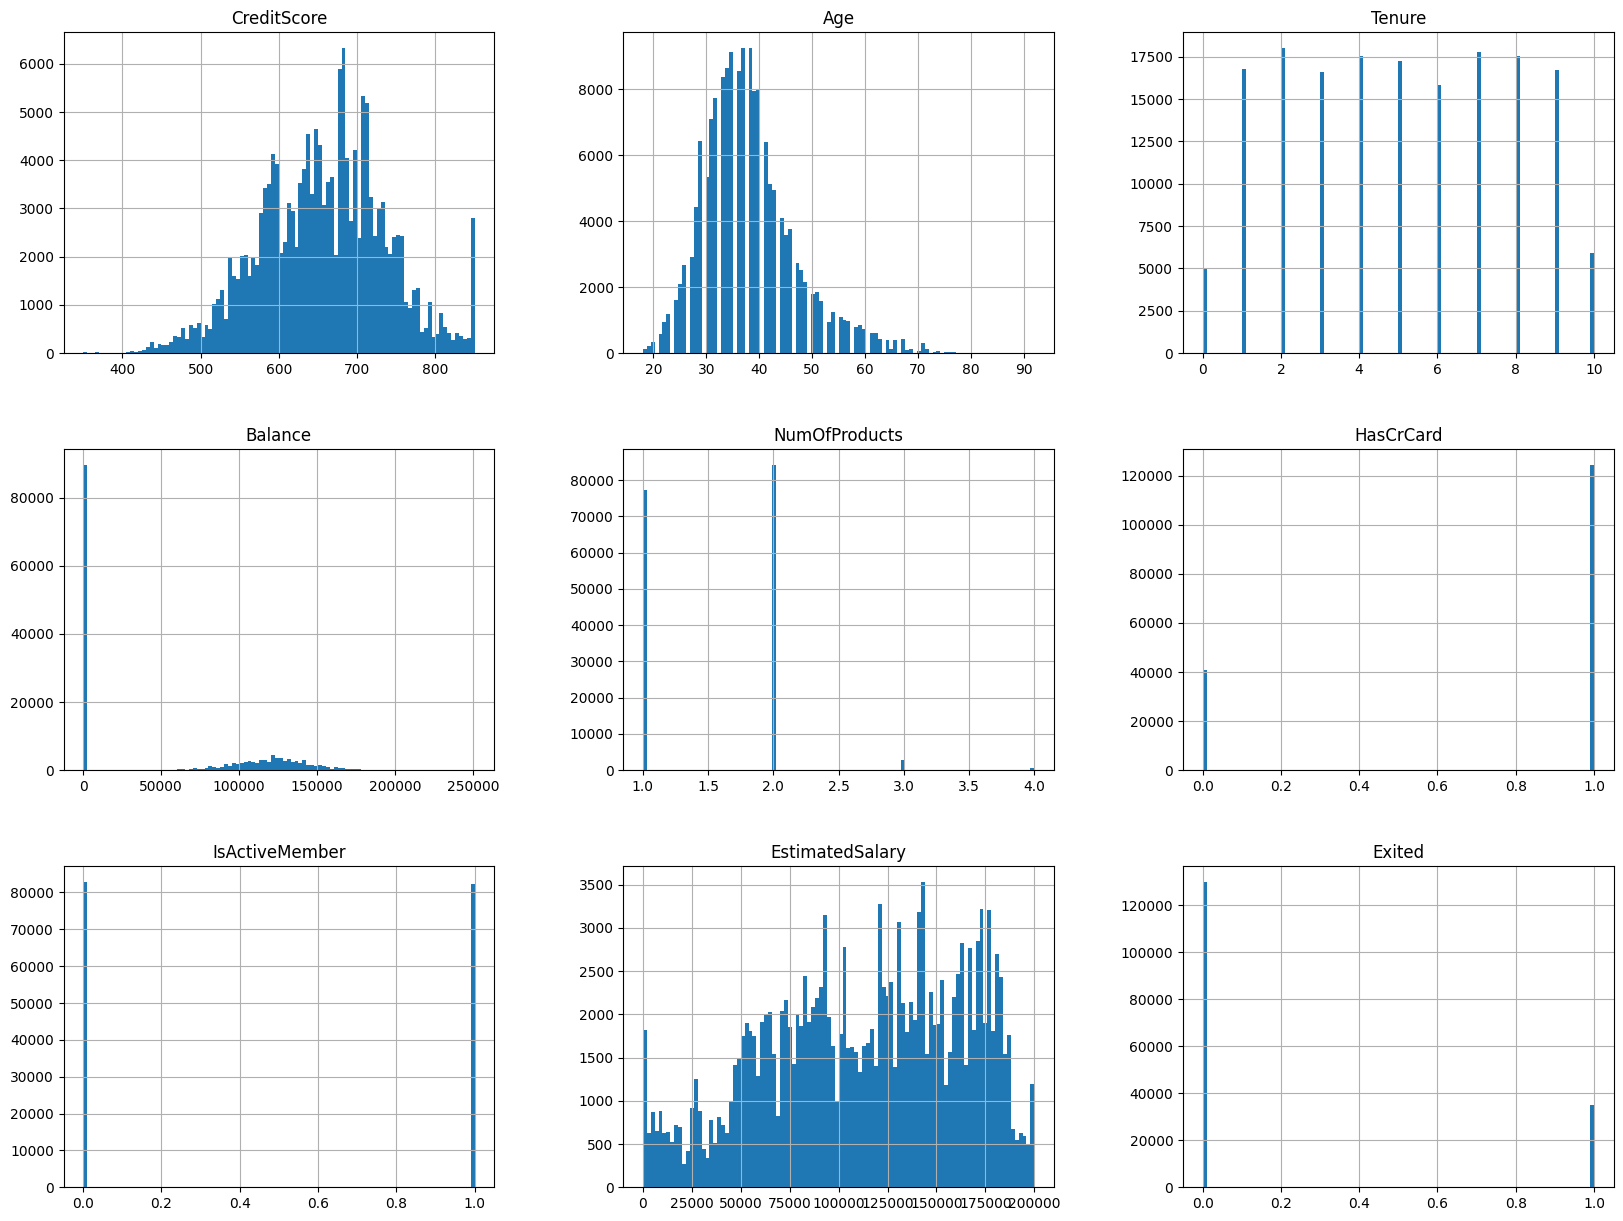

In [112]:
train.iloc[:,2:].hist(figsize=(20,15), bins=100)
plt.show()

In [113]:
numerical_cols = train.columns[train.dtypes != "O"].drop(["id","CustomerId","Exited"])
categorical_cols = train.columns[train.dtypes == "O"].drop("Surname")

In [115]:
numerical_cols, categorical_cols

(Index(['CreditScore', 'Age', 'Tenure', 'Balance', 'NumOfProducts', 'HasCrCard',
        'IsActiveMember', 'EstimatedSalary'],
       dtype='object'),
 Index(['Geography', 'Gender'], dtype='object'))

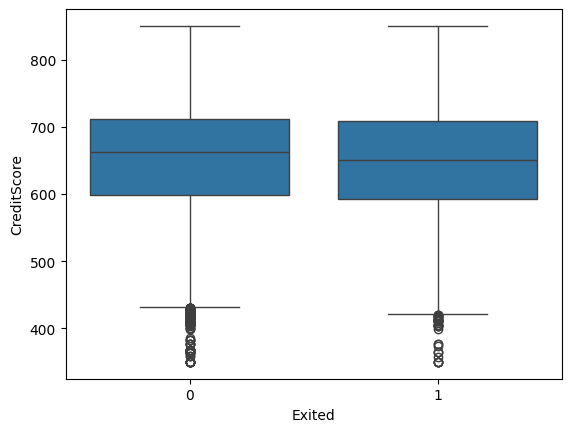

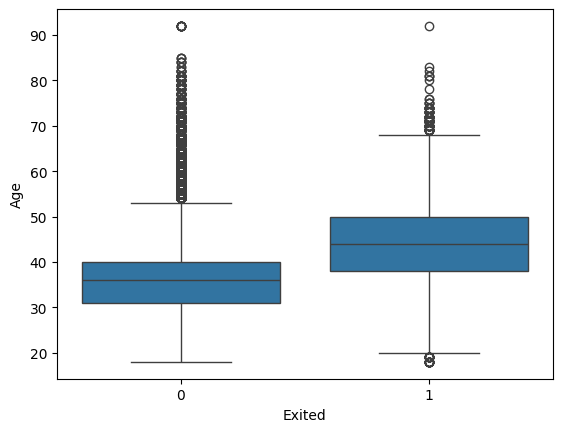

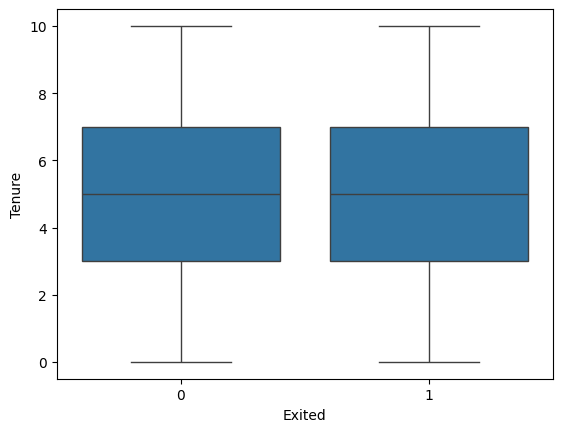

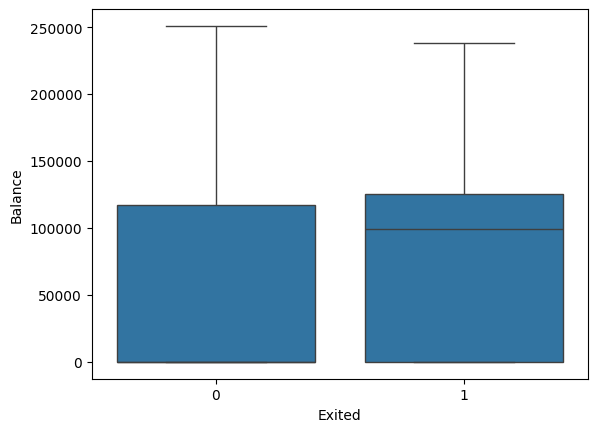

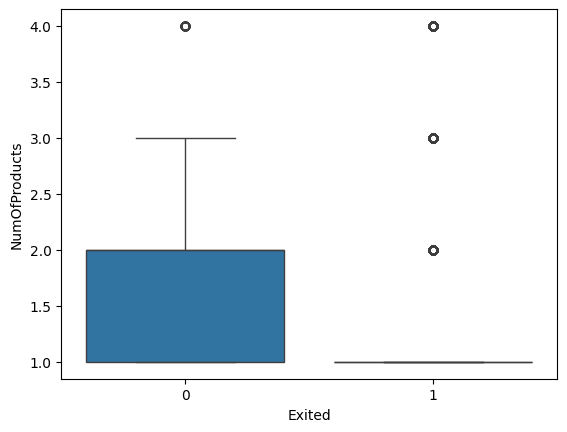

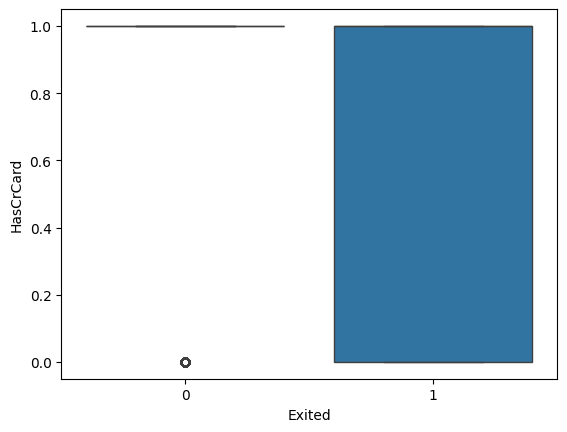

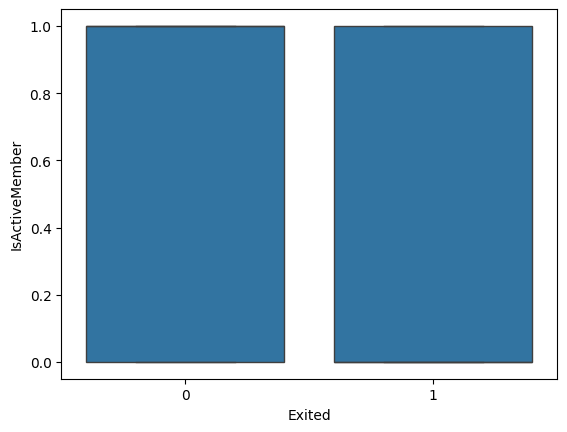

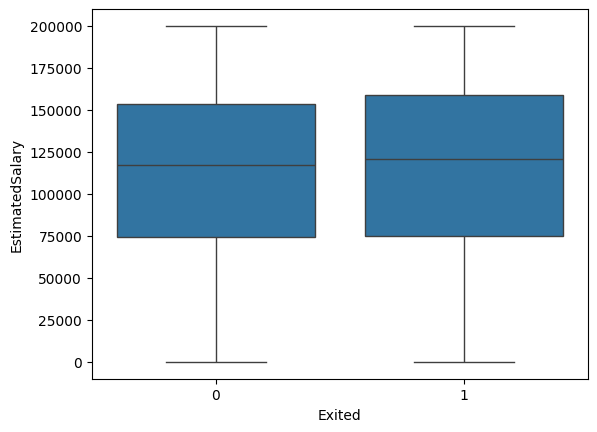

In [116]:
for col in numerical_cols:
    sns.boxplot(train, x = "Exited", y = col)
    plt.show()

In [117]:
for col in categorical_cols:
    print(train.groupby(["Exited",col])["id"].count() / train.groupby(["Exited"])["id"].count())

Exited  Geography
0       France       0.604421
        Germany      0.165179
        Spain        0.230400
1       France       0.445921
        Germany      0.375533
        Spain        0.178546
Name: id, dtype: float64
Exited  Gender
0       Female    0.397954
        Male      0.602046
1       Female    0.575728
        Male      0.424272
Name: id, dtype: float64


In [118]:
train_inputs = train.drop(columns=["Exited"])
train_targets = train["Exited"]
test_inputs = test.copy()

dropped_columns = ['id', 'CustomerId','Surname']

train_inputs.drop(columns=dropped_columns, inplace=True)
test_inputs.drop(columns=dropped_columns, inplace=True)

encoder = LabelEncoder()

for col in categorical_cols:
    train_inputs[col] = encoder.fit_transform(train_inputs[col])
    test_inputs[col] = encoder.transform(test_inputs[col])

In [124]:
1 / train.Exited.value_counts(normalize=True)

Exited
0    1.268390
1    4.725924
Name: proportion, dtype: float64

In [125]:
lgbm = LGBMClassifier(class_weight={0 : 1.268390, 1: 4.725924})

scoring = make_scorer(roc_auc_score)
scores = cross_val_score(lgbm, train_inputs, train_targets, cv= 5, scoring= scoring)

print(f"AUC = {np.mean(scores):.3}")

[LightGBM] [Info] Number of positive: 27937, number of negative: 104090
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.014942 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 859
[LightGBM] [Info] Number of data points in the train set: 132027, number of used features: 10
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500003 -> initscore=0.000011
[LightGBM] [Info] Start training from score 0.000011
[LightGBM] [Info] Number of positive: 27937, number of negative: 104090
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.010153 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 857
[LightGBM] [Info] Number of data points in the train set: 132027, number of used features: 10
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500003 -> initscore=0.000011
[LightGBM] [Info] Start training from score 0.000011
[LightGBM] [In

In [126]:
lgbm.fit(train_inputs,train_targets)
test_predictions = lgbm.predict_proba(test_inputs)[:,1]

[LightGBM] [Info] Number of positive: 34921, number of negative: 130113
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002878 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 859
[LightGBM] [Info] Number of data points in the train set: 165034, number of used features: 10
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000


<Axes: title={'center': 'Feature importance'}, xlabel='Feature importance', ylabel='Features'>

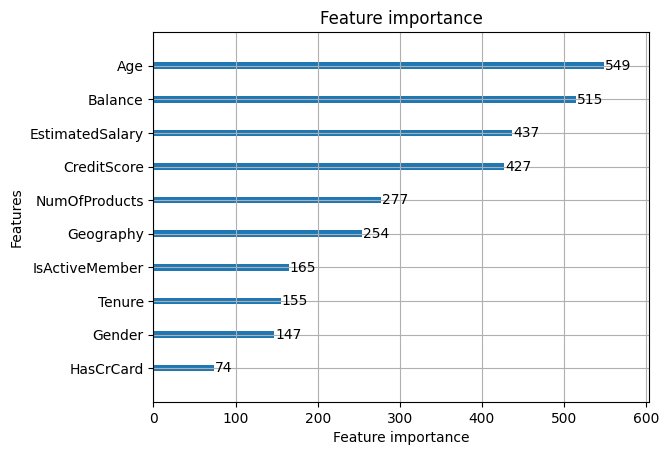

In [127]:
import lightgbm
lightgbm.plot_importance(lgbm)

In [128]:
ss["Exited"] = test_predictions
ss.to_csv("Submission.csv", index=False)